In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas
from linearmodels.panel import PooledOLS
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
import re
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from sklearn import preprocessing

# 1. VAR Process

In the data `raotb16.csv` we have some macroeconomic data.

1. Test which series Granger cause each other.

2. Test which series are stationary

3. Fit a VAR on the system of time series. Find the best number of lags. Don't forget to differentiate the series that need it.

4. Fit a VAR on everything except the last 12 months (4 quarters) of the data. Backtest your model against the actual last year in the data. Plot the predictions against the data for each series.

In [2]:
df = pd.read_csv(r'C:\Users\David\Documents\code\Mod_5\5-6-var-panel\data\raotb16.csv')
df.date = dates_from_str(df.date)
df = df.set_index('date')

# Let's get stationarity for VAR. This procedure is simple (after many trials), we simply need the second difference.
ori_df = df.copy()

df = df.diff().dropna()
df = df.diff().dropna()

In [3]:
#1.
#We need a VAR model to find the Granger causality
model = VAR(df)
results = model.fit(2)
cols = list(df)

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        print(results.test_causality( df.columns[i], df.columns[j], kind='f').summary())

#see results below

6)
----------------------------------------------
Granger causality F-test. H_0: rgnp does not Granger-cause pgnp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.989          3.007   0.137 (2, 816)
----------------------------------------------
Granger causality F-test. H_0: pgnp does not Granger-cause pgnp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.5731          3.007   0.564 (2, 816)
----------------------------------------------
Granger causality F-test. H_0: ulc does not Granger-cause pgnp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.5365          3.007   0.585 (2, 816)
----------------------------------------------
Granger causality F-t

In [4]:
#2.
#We can use Dickey-Fuller to test stationarity.
print('     Working dataset     ')
for col in df.columns:
    print(adfuller(df[col])[1])

print('     Original dataset    ')
for col in ori_df.columns:
    print(adfuller(ori_df[col])[1])
#With those p-values, it is clear that none of them are stationary

     Working dataset     
2.4878569242374744e-15
2.6204782825958454e-20
1.698194036505457e-14
2.4994349960269606e-14
0.0003970261107768556
2.4677235564632886e-16
2.1400722424589626e-10
0.000328071866991873
     Original dataset    
0.988603711430595
0.9964612064726059
0.997099172882968
0.9870138472785788
0.9953249001658119
0.9386740229058365
0.998051164027281
0.8144015307501978


In [5]:
#3.
model = VAR(df)
results = model.fit(maxlags=4, ic='aic')
results.summary()
#In observing the aic, it seems to prefer 4 lags.

C:\Users\David\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


    0.469
L1.gdfim        -0.062472         0.095551           -0.654           0.513
L1.gdfcf         0.199226         0.135757            1.468           0.142
L1.gdfce        -0.041525         0.052382           -0.793           0.428
L2.rgnp          0.002929         0.003712            0.789           0.430
L2.pgnp         -0.107473         0.114613           -0.938           0.348
L2.ulc           0.024764         0.119352            0.207           0.836
L2.gdfco        -0.117895         0.295615           -0.399           0.690
L2.gdf          -0.058543         0.561435           -0.104           0.917
L2.gdfim        -0.115772         0.099469           -1.164           0.244
L2.gdfcf        -0.002687         0.165784           -0.016           0.987
L2.gdfce         0.072392         0.064452            1.123           0.261
L3.rgnp          0.002980         0.003556            0.838           0.402
L3.pgnp         -0.038196         0.122522           -0.312           0.755
L3

C:\Users\David\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
<ipython-input-6-8a4331042cd1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df['forecast_' + col] = fore_df[col]


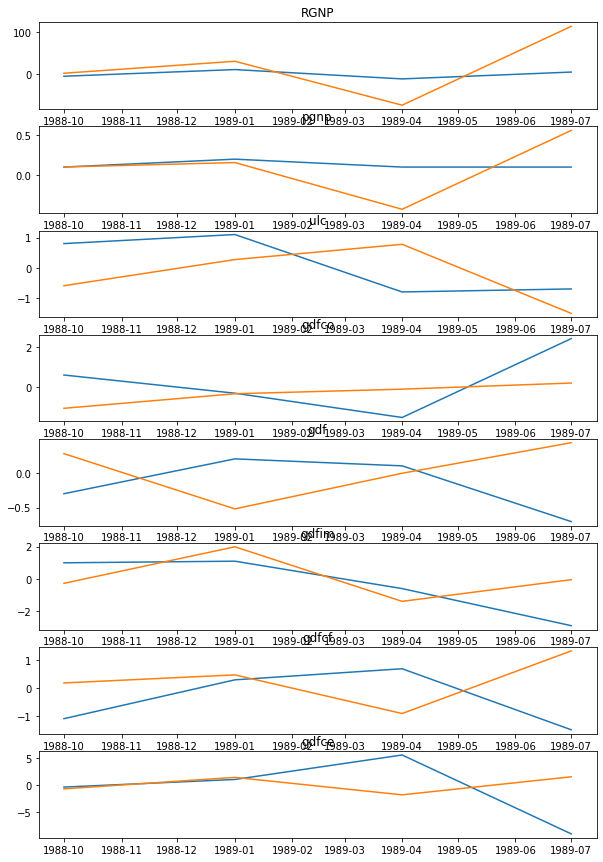

In [6]:
#4.
model = VAR(df[:-4])
results = model.fit(maxlags=4, ic='aic')
forec = results.forecast(y=df[-4:].values, steps=4)

true_df = df[-4:]
fore_df = pd.DataFrame(forec, columns=true_df.columns, index=true_df.index)

for col in fore_df.columns:
    true_df['forecast_' + col] = fore_df[col]

fig, (ax,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(8,1, figsize=(10, 15))
ax.title.set_text('RGNP')
ax.plot(true_df.rgnp)
ax.plot(true_df.forecast_rgnp)
ax1.title.set_text('pgnp')
ax1.plot(true_df.pgnp)
ax1.plot(true_df.forecast_pgnp)
ax2.title.set_text('ulc')
ax2.plot(true_df.ulc)
ax2.plot(true_df.forecast_ulc)
ax3.title.set_text('gdfco')
ax3.plot(true_df.gdfco)
ax3.plot(true_df.forecast_gdfco)
ax4.title.set_text('gdf')
ax4.plot(true_df.gdf)
ax4.plot(true_df.forecast_gdf)
ax5.title.set_text('gdfim')
ax5.plot(true_df.gdfim)
ax5.plot(true_df.forecast_gdfim)
ax6.title.set_text('gdfcf')
ax6.plot(true_df.gdfcf)
ax6.plot(true_df.forecast_gdfcf)
ax7.title.set_text('gdfce')
ax7.plot(true_df.gdfce)
ax7.plot(true_df.forecast_gdfce)

#Not looking like an accurate forecast

# 2. Gun Violence Panel

The [Gun Violence](https://www.kaggle.com/jameslko/gun-violence-data) dataset

1. Transform it into an amenable panel (or structure of multiple time series) to analyze and create a forecast for the next year outside the sample in **Chicago**, **Washington** and **New Orleans**, and the US as a whole.

2. Are there other (non time series) predictors which could be used in this dataset to help predict severity or number of shootings in the future? Analyze the data for feature importance and explain your findings.

In [8]:
df = pd.read_csv(r'C:\Users\David\Documents\code\Mod_5\5-6-var-panel\archive\gun-violence-data_01-2013_03-2018.csv')
ori_df = df.copy()

df.date = dates_from_str(df.date)
df['year'] = df.date.apply(lambda x: x.year)
df['year_'] = df.year
df['incident'] = 1 #just a counter so we can measure raw incidents even if nobody died/were injured
df = df.groupby(['year','year_', 'state'], as_index=False).sum()

le = preprocessing.LabelEncoder() #We will need this to return our original labels later
le.fit(df.state)
df.state = le.transform(df.state)

df = df.set_index(['year','state'])

exog_vars = ['year_']
X = sm.add_constant(df[exog_vars])
mod = RandomEffects(df['incident'].fillna(0), X)
re_res = mod.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:               incident   R-squared:                       -0.0012
Estimator:              RandomEffects   R-squared (Between):              0.0429
No. Observations:                 292   R-squared (Within):               0.0000
Date:                Fri, Apr 30 2021   R-squared (Overall):             -0.0009
Time:                        15:34:56   Log-likelihood                   -2388.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                     -0.3601
Entities:                           6   P-value                           1.0000
Avg Obs:                       48.667   Distribution:                   F(1,290)
Min Obs:                       37.000                                           
Max Obs:                       51.000   F-statistic (robust):             0.1692
                            

In [25]:
#2. THere are clearly features which would better inform this regression. A simple check for feature importance would be to load everything up into OLS and check the coefficients. 

# I found the most interesting interaction is with the states. It seems as though some states with high gun violence have low p-value and high coefficient. In other states it seems hardly relevant.

#Note: I really really really wish I had the time to data clean the features such as gender/gun stolen/etc (and would if this wasn't the last minute).
df = pd.read_csv(r'C:\Users\David\Documents\code\Mod_5\5-6-var-panel\archive\gun-violence-data_01-2013_03-2018.csv')

df.date = dates_from_str(df.date)
df['year'] = df.date.apply(lambda x: x.year)
df['year_'] = df.year
df['incident'] = 1
df.n_guns_involved = df.n_guns_involved.fillna(0)
df = df.groupby(['year','year_', 'state'], as_index=False).sum()

df = df.set_index(['year','incident_id'])

exog_vars = ['year_','n_injured', 'incident', 'n_guns_involved']
X = sm.add_constant(df[exog_vars])
X  = X.join(pd.get_dummies(df.state, drop_first=True))
# X  = X.join(pd.get_dummies(df.state, drop_first=True))
mod = sm.OLS(df['n_killed'].fillna(0), X)
re_res = mod.fit()
print(re_res.summary())

                            OLS Regression Results                            
Dep. Variable:               n_killed   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     113.9
Date:                Fri, 30 Apr 2021   Prob (F-statistic):          3.52e-142
Time:                        17:43:39   Log-Likelihood:                -1567.0
No. Observations:                 292   AIC:                             3244.
Df Residuals:                     237   BIC:                             3446.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2464.0029 